In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from sklearn.metrics import mean_squared_error
from smt.explainability_tools import (
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay,
    ShapFeatureImportanceDisplay,
    ShapDisplay,
)

import time
import numpy as np


In [2]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

def cantilever_deflection_vectorized(X):
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = cantilever_deflection(X[i, :])
    return y

class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)

In [3]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    CategoricalVariable([
        "type_A", "type_B", "type_C", "type_D", 
        "type_E", "type_F", "type_G", "type_H", 
        "type_I", "type_J", "type_K", "type_L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 200
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

CPU times: user 2.54 s, sys: 13.7 ms, total: 2.55 s
Wall time: 2.56 s


In [4]:
class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)
    
sm = GroundTruthModel()
start_time = time.time()
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

    

RMSE: 0.0000
rRMSE: 0.0000


CPU times: user 169 ms, sys: 6.84 ms, total: 176 ms
Wall time: 173 ms


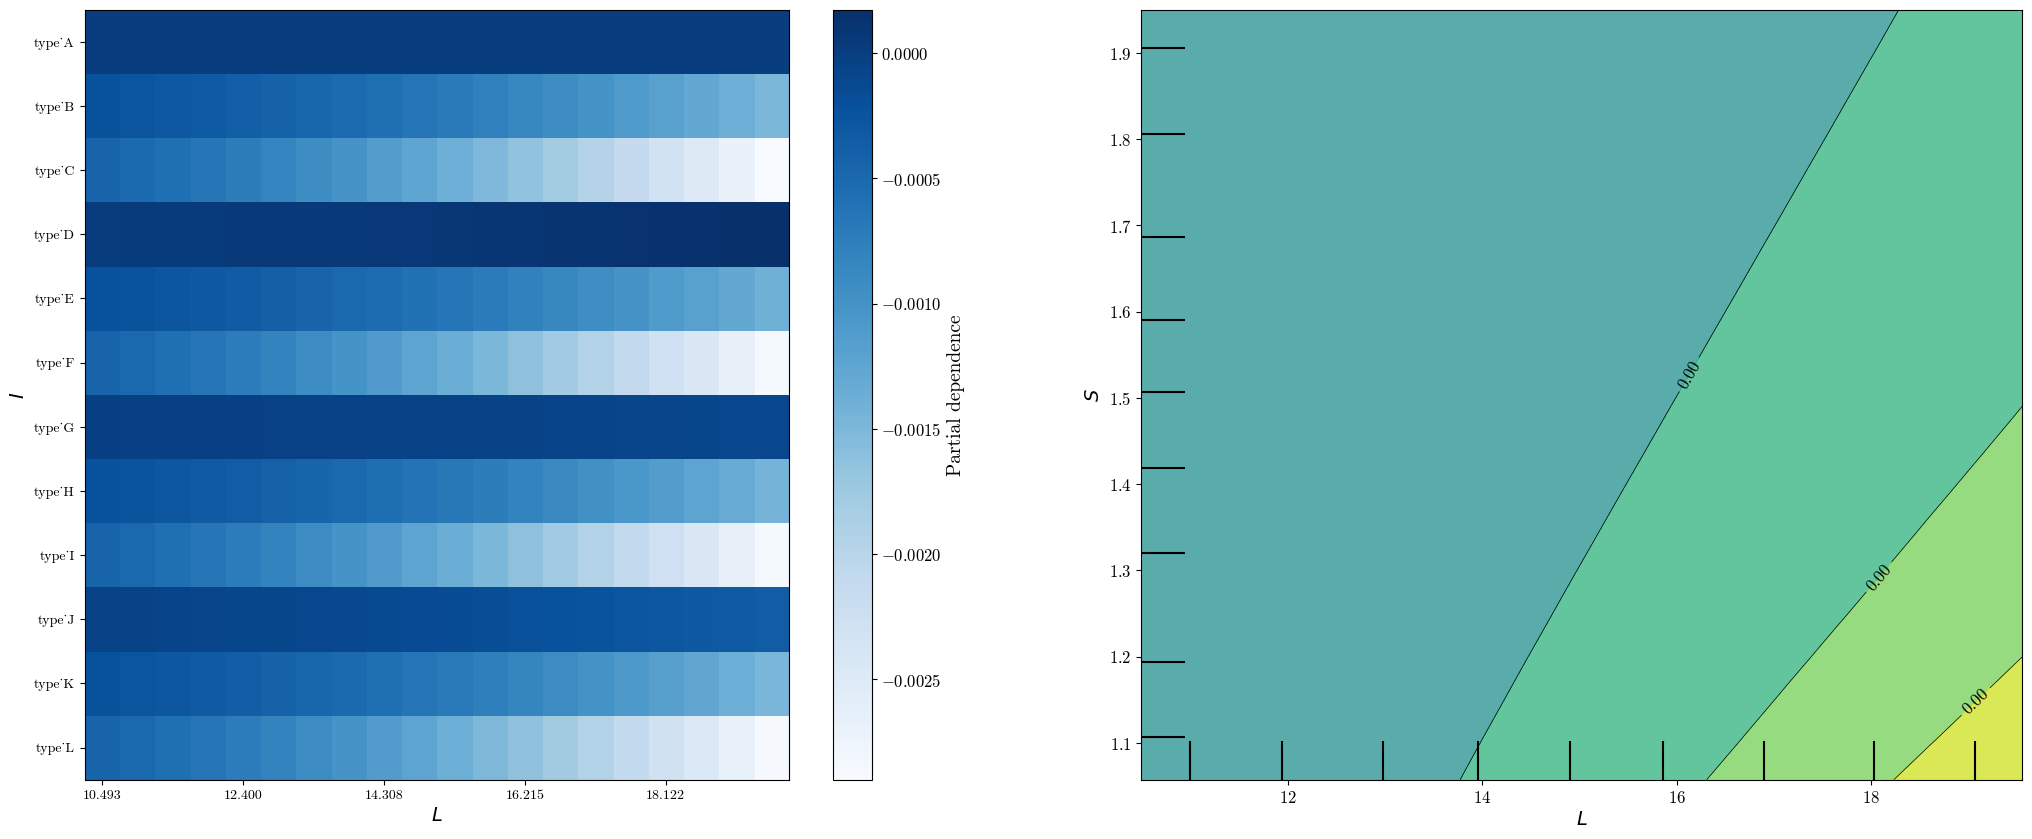

In [5]:
%%time
model = sm
X = X_tr
features = [(0, 1), (1, 2,)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 157 ms, sys: 4.34 ms, total: 162 ms
Wall time: 154 ms


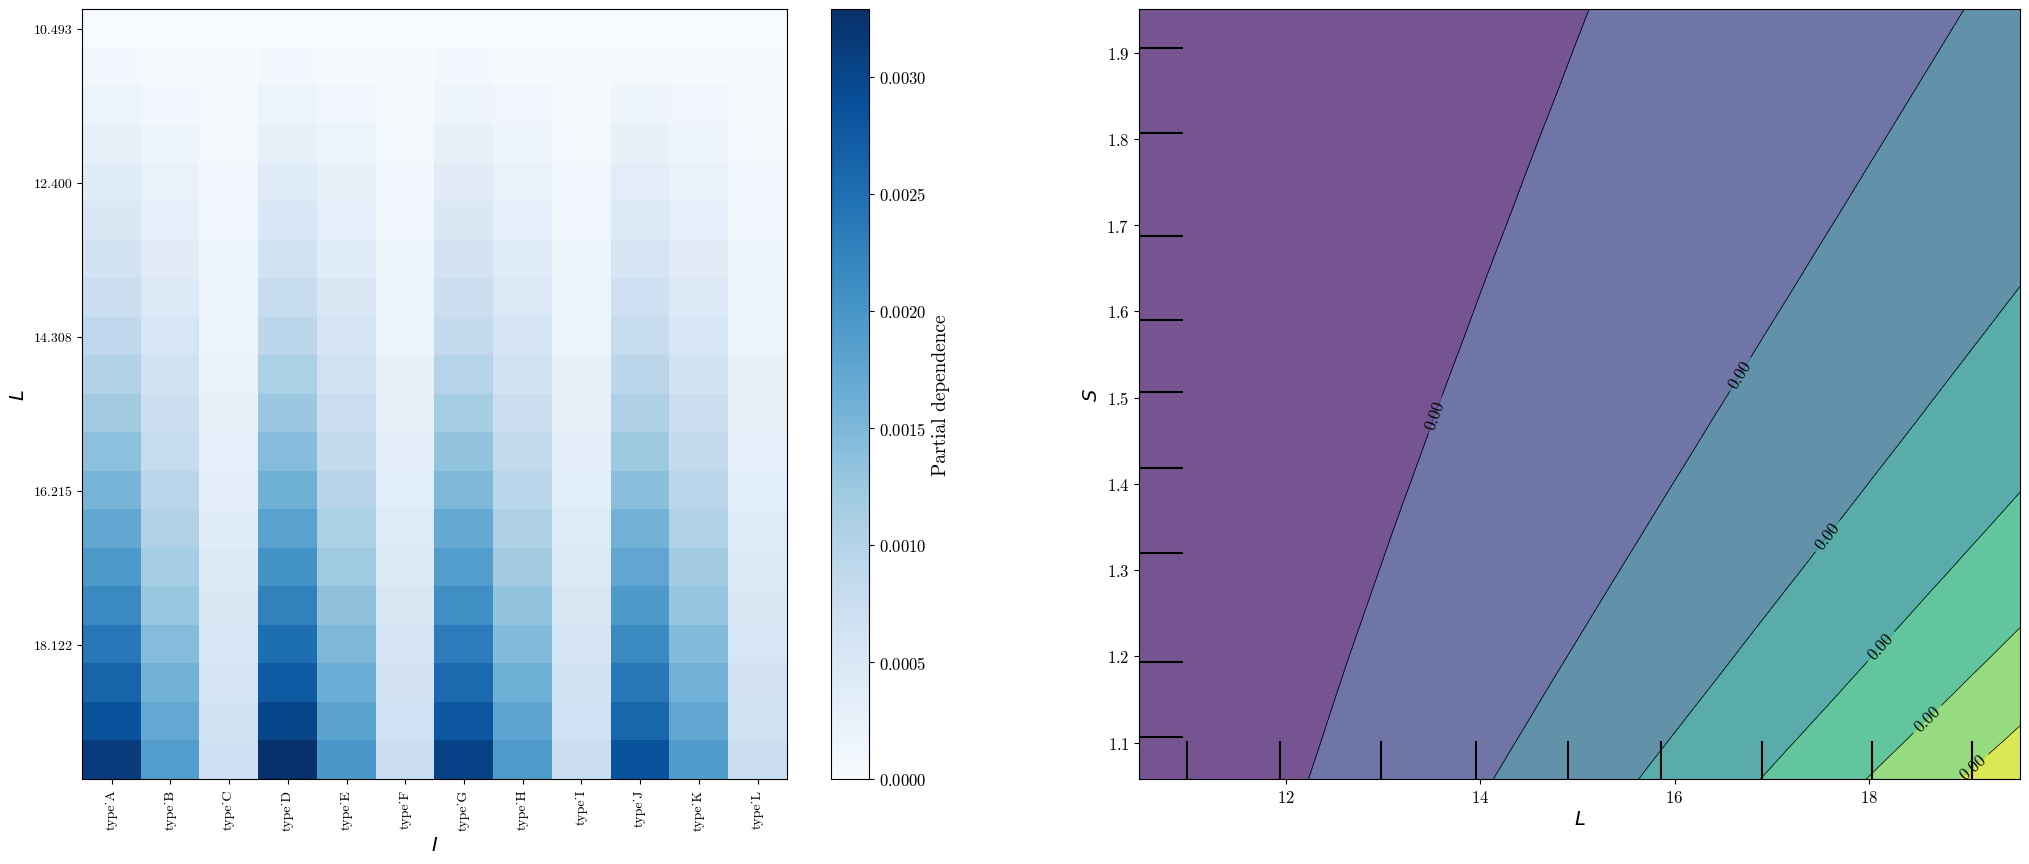

In [6]:
%%time
model = sm
X = X_tr
features = [(1, 0), (1, 2,)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )

In [7]:
n = 5
length = 3
delta = max(length // n, 1)

np.arange(0, length, delta)

array([0, 1, 2])

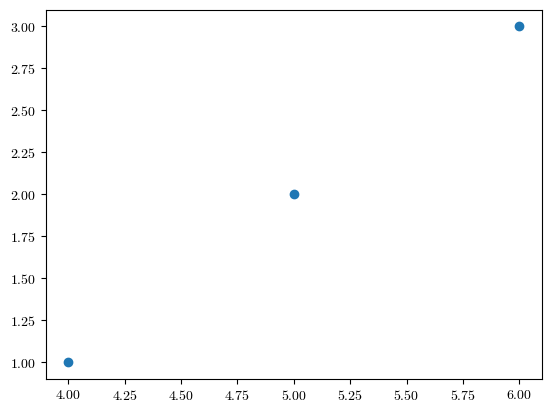

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter([4, 5, 6], [1, 2, 3])
# ax.set_xticks([4, 5, 6], rotation="vertical")
# ax.tick_params(axis="x", rotation=90, format=lambda x, _: f"{x:.3f}")
# ax.xticklabels([4, 5, 6], format=lambda x, _: f"{x:.3f}")

In [9]:
pdd.pd_results[0]

{'grid_values': [array([10.49296972, 10.96981401, 11.44665829, 11.92350258, 12.40034687,
         12.87719116, 13.35403545, 13.83087974, 14.30772403, 14.78456832,
         15.26141261, 15.7382569 , 16.21510119, 16.69194548, 17.16878976,
         17.64563405, 18.12247834, 18.59932263, 19.07616692, 19.55301121]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])],
 'grid_categories': [array([], dtype=float64),
  array(['type_A', 'type_B', 'type_C', 'type_D', 'type_E', 'type_F',
         'type_G', 'type_H', 'type_I', 'type_J', 'type_K', 'type_L'],
        dtype='<U6')],
 'average': array([[0.00057405, 0.00034401, 0.00012584, 0.00060073, 0.00035953,
         0.00013173, 0.00055667, 0.0003516 , 0.00013283, 0.00051863,
         0.00034651, 0.00012959],
        [0.00065592, 0.00039308, 0.00014378, 0.00068641, 0.00041081,
         0.00015052, 0.00063606, 0.00040175, 0.00015177, 0.0005926 ,
         0.00039593, 0.00014807],
        [0.00074522, 0.0004466 , 0.00016336, 0.0007

In [10]:
pdd.pd_results[1]

{'grid_values': [array([10.49296972, 10.96981401, 11.44665829, 11.92350258, 12.40034687,
         12.87719116, 13.35403545, 13.83087974, 14.30772403, 14.78456832,
         15.26141261, 15.7382569 , 16.21510119, 16.69194548, 17.16878976,
         17.64563405, 18.12247834, 18.59932263, 19.07616692, 19.55301121]),
  array([1.05726335, 1.10424869, 1.15123403, 1.19821937, 1.24520471,
         1.29219005, 1.33917538, 1.38616072, 1.43314606, 1.4801314 ,
         1.52711674, 1.57410208, 1.62108742, 1.66807275, 1.71505809,
         1.76204343, 1.80902877, 1.85601411, 1.90299945, 1.94998479])],
 'average': array([[0.00064787, 0.00059391, 0.00054642, 0.00050441, 0.00046706,
         0.00043371, 0.00040381, 0.0003769 , 0.00035259, 0.00033056,
         0.00031053, 0.00029227, 0.00027558, 0.00026027, 0.0002462 ,
         0.00023325, 0.00022129, 0.00021023, 0.00019998, 0.00019045],
        [0.00074027, 0.00067861, 0.00062435, 0.00057635, 0.00053367,
         0.00049557, 0.0004614 , 0.00043065, 0.0004